In [22]:
import pandas as pd
import string
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import numpy as np
from tensorflow.keras import datasets, layers, models
import tensorflow
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, confusion_matrix

2023-05-18 15:05:17.660190: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-18 15:05:17.660217: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [23]:
allData = pd.read_csv('../feature_data/features.csv')
allData.replace([np.inf, -np.inf], np.nan, inplace=True)
allData = allData.dropna()
X = allData.drop(["label"],axis=1)
X = X.drop(["radius"],axis=1)
cols = X.keys()

#normalize data
X = preprocessing.normalize(X, norm='max')

#labels
y = allData["label"]

#features
X = pd.DataFrame(X, columns = cols)

X['label'] = y


X = pd.DataFrame(X, columns = cols)


In [24]:
X.describe()

,num_points,std,avg_median_dev,width,linearity,circularity,boundary_length,boundary_regularity,mean_curvature,ang_diff,iav,std_iav,distance,dist_num_points,occluded_right,occluded_left
count,9489.000000,9489.000000,9489.000000,9489.000000,9489.000000,9.489000e+03,9489.000000,9489.000000,9489.000000,9489.000000,9489.000000,9489.000000,9489.000000,9489.000000,9489.000000,9489.000000
mean,0.591876,0.006595,0.005354,0.018044,0.080554,1.073564e-03,0.021039,0.001622,0.746893,0.131135,0.155018,0.123128,0.264434,0.053376,0.051616,0.044787
std,0.301662,0.006057,0.004928,0.017596,0.216024,4.462697e-03,0.018928,0.002130,0.356924,0.085117,0.096798,0.118237,0.311487,0.089121,0.056148,0.053842
min,0.013108,0.000091,0.000083,0.000258,0.000003,2.989823e-16,0.000450,0.000004,0.001178,0.000784,0.000784,0.000072,0.000755,0.000003,0.000000,0.000000
25%,0.324496,0.001434,0.001189,0.003823,0.000417,8.500852e-06,0.005043,0.000228,0.410400,0.064074,0.077845,0.037257,0.041221,0.002814,0.012499,0.000000
50%,0.515469,0.004599,0.003765,0.011499,0.001413,3.110597e-05,0.014725,0.000697,1.000000,0.109722,0.136684,0.074860,0.114122,0.011405,0.033159,0.027403
75%,1.000000,0.010100,0.007916,0.026915,0.035819,2.910429e-04,0.032701,0.002027,1.000000,0.179543,0.211140,0.182841,0.375337,0.057234,0.072341,0.061478
max,1.000000,0.037908,0.029587,0.096485,1.000000,1.014070e-01,0.100089,0.019309,1.000000,0.448640,0.663490,0.792277,1.000000,0.333334,0.333333,0.333333


<AxesSubplot:>

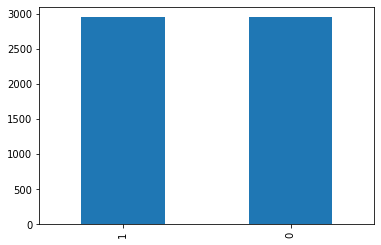

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)
y_train.value_counts().plot.bar()


#oversample the minority
ros = RandomOverSampler(sampling_strategy="minority")
X_train, y_train = ros.fit_resample(X_train, y_train)

y_train.value_counts().plot.bar()

In [28]:
def CNN_Model(filters1 = 32, filters2=64, kernel_size=3,strides=1, pool_size=4, optimizer = 'adam'):
    model = models.Sequential()
    model.add(layers.Conv1D(filters=filters1, kernel_size=kernel_size, strides=strides, activation='relu',input_shape=(16,1)))
    #model.add(layers.MaxPooling1D(pool_size=pool_size,strides=strides))
    model.add(layers.Conv1D(filters=filters2, kernel_size=kernel_size, strides=strides, activation='relu'))

    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(2))
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model
    

In [35]:
ms = []
hs = []
#for p in [3,4,5]:
for k in [5]:
    #    for s in [1]:
    #if not (s==2 and k==4):
    #print(k)
    #print(s)
    model = CNN_Model(filters1=64, filters2 = 64,kernel_size=k)# pool_size=p,strides=s
    model.summary()
    ms.append(model)
    history = model.fit(X_train, y_train, epochs=150, 
                    validation_data=(X_val, y_val))
    hs.append(history)


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 12, 64)            384       
                                                                 
 conv1d_19 (Conv1D)          (None, 8, 64)             20544     
                                                                 
 flatten_9 (Flatten)         (None, 512)               0         
                                                                 
 dense_18 (Dense)            (None, 32)                16416     
                                                                 
 dense_19 (Dense)            (None, 2)                 66        
                                                                 
Total params: 37,410
Trainable params: 37,410
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
185/185 [=============================

185/185 [==============================] - 1s 3ms/step - loss: 0.0995 - accuracy: 0.9586 - val_loss: 0.1089 - val_accuracy: 0.9521
Epoch 51/150
185/185 [==============================] - 1s 3ms/step - loss: 0.0989 - accuracy: 0.9568 - val_loss: 0.1126 - val_accuracy: 0.9510
Epoch 52/150
185/185 [==============================] - 1s 3ms/step - loss: 0.0997 - accuracy: 0.9575 - val_loss: 0.1096 - val_accuracy: 0.9536
Epoch 53/150
185/185 [==============================] - 1s 3ms/step - loss: 0.0992 - accuracy: 0.9561 - val_loss: 0.1053 - val_accuracy: 0.9557
Epoch 54/150
185/185 [==============================] - 1s 4ms/step - loss: 0.0971 - accuracy: 0.9583 - val_loss: 0.1106 - val_accuracy: 0.9531
Epoch 55/150
185/185 [==============================] - 1s 3ms/step - loss: 0.0998 - accuracy: 0.9583 - val_loss: 0.1026 - val_accuracy: 0.9557
Epoch 56/150
185/185 [==============================] - 1s 3ms/step - loss: 0.0971 - accuracy: 0.9595 - val_loss: 0.1164 - val_accuracy: 0.9542
Epoch

Epoch 107/150
185/185 [==============================] - 1s 5ms/step - loss: 0.0736 - accuracy: 0.9702 - val_loss: 0.1136 - val_accuracy: 0.9579
Epoch 108/150
185/185 [==============================] - 1s 5ms/step - loss: 0.0751 - accuracy: 0.9700 - val_loss: 0.1098 - val_accuracy: 0.9600
Epoch 109/150
185/185 [==============================] - 1s 5ms/step - loss: 0.0726 - accuracy: 0.9703 - val_loss: 0.1100 - val_accuracy: 0.9615
Epoch 110/150
185/185 [==============================] - 1s 5ms/step - loss: 0.0736 - accuracy: 0.9697 - val_loss: 0.1110 - val_accuracy: 0.9589
Epoch 111/150
185/185 [==============================] - 1s 5ms/step - loss: 0.0716 - accuracy: 0.9697 - val_loss: 0.1193 - val_accuracy: 0.9568
Epoch 112/150
185/185 [==============================] - 1s 5ms/step - loss: 0.0775 - accuracy: 0.9685 - val_loss: 0.1163 - val_accuracy: 0.9557
Epoch 113/150
185/185 [==============================] - 1s 5ms/step - loss: 0.0720 - accuracy: 0.9703 - val_loss: 0.1197 - val_ac

60/60 - 0s - loss: 0.1263 - accuracy: 0.9515 - 100ms/epoch - 2ms/step
Test Loss: 0.12628376483917236
Test Accuracy: 0.9515279531478882


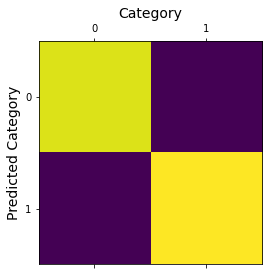

1    972
0    926
Name: label, dtype: int64
              precision    recall  f1-score   support

           0     0.9503    0.9503    0.9503       926
           1     0.9527    0.9527    0.9527       972

    accuracy                         0.9515      1898
   macro avg     0.9515    0.9515    0.9515      1898
weighted avg     0.9515    0.9515    0.9515      1898

60/60 - 0s - loss: 0.1356 - accuracy: 0.9505 - 95ms/epoch - 2ms/step
Test Loss: 0.13558794558048248
Test Accuracy: 0.950474202632904


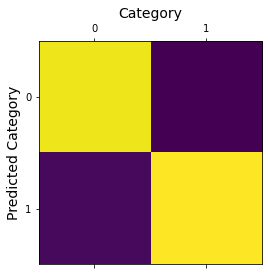

1    972
0    926
Name: label, dtype: int64
              precision    recall  f1-score   support

           0     0.9611    0.9388    0.9498       948
           1     0.9403    0.9621    0.9511       950

    accuracy                         0.9505      1898
   macro avg     0.9507    0.9505    0.9505      1898
weighted avg     0.9507    0.9505    0.9505      1898

60/60 - 0s - loss: 0.1130 - accuracy: 0.9515 - 98ms/epoch - 2ms/step
Test Loss: 0.11302242428064346
Test Accuracy: 0.9515279531478882


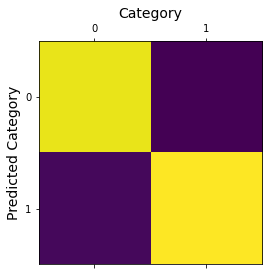

1    972
0    926
Name: label, dtype: int64
              precision    recall  f1-score   support

           0     0.9600    0.9417    0.9508       944
           1     0.9434    0.9612    0.9522       954

    accuracy                         0.9515      1898
   macro avg     0.9517    0.9515    0.9515      1898
weighted avg     0.9517    0.9515    0.9515      1898

60/60 - 0s - loss: 0.1221 - accuracy: 0.9526 - 101ms/epoch - 2ms/step
Test Loss: 0.1221219077706337
Test Accuracy: 0.9525816440582275


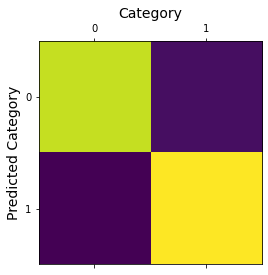

1    972
0    926
Name: label, dtype: int64
              precision    recall  f1-score   support

           0     0.9330    0.9686    0.9505       892
           1     0.9712    0.9384    0.9545      1006

    accuracy                         0.9526      1898
   macro avg     0.9521    0.9535    0.9525      1898
weighted avg     0.9533    0.9526    0.9526      1898

60/60 - 0s - loss: 0.1130 - accuracy: 0.9615 - 96ms/epoch - 2ms/step
Test Loss: 0.11298485845327377
Test Accuracy: 0.9615384340286255


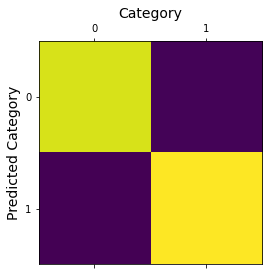

1    972
0    926
Name: label, dtype: int64
              precision    recall  f1-score   support

           0     0.9557    0.9651    0.9604       917
           1     0.9671    0.9582    0.9626       981

    accuracy                         0.9615      1898
   macro avg     0.9614    0.9617    0.9615      1898
weighted avg     0.9616    0.9615    0.9615      1898

60/60 - 0s - loss: 0.1188 - accuracy: 0.9579 - 107ms/epoch - 2ms/step
Test Loss: 0.11877378821372986
Test Accuracy: 0.9578503966331482


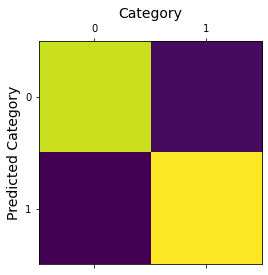

1    972
0    926
Name: label, dtype: int64
              precision    recall  f1-score   support

           0     0.9428    0.9700    0.9562       900
           1     0.9722    0.9469    0.9594       998

    accuracy                         0.9579      1898
   macro avg     0.9575    0.9584    0.9578      1898
weighted avg     0.9583    0.9579    0.9579      1898



In [17]:
for m in ms:
    test_loss, test_acc = m.evaluate(X_test,  y_test, verbose=2)
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_acc)
    
    y_pred = np.argmax(m.predict(X_test), axis=-1)
    plt.matshow(confusion_matrix(y_test, y_pred, labels=[0,1]))
    plt.ylabel("Predicted Category", fontsize=14)
    plt.title("Category", fontsize=14)
    plt.show()
    print(y_test.value_counts())
    print(classification_report(y_pred,y_test,digits=4))

60/60 - 0s - loss: 0.1075 - accuracy: 0.9647 - 124ms/epoch - 2ms/step
Test Loss: 0.10752040147781372
Test Accuracy: 0.9646996855735779


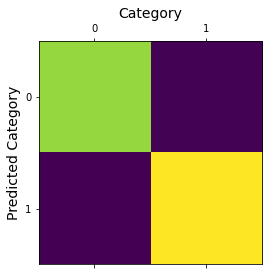

1    1021
0     877
Name: label, dtype: int64
              precision    recall  f1-score   support

           0     0.9578    0.9655    0.9616       870
           1     0.9706    0.9640    0.9673      1028

    accuracy                         0.9647      1898
   macro avg     0.9642    0.9648    0.9645      1898
weighted avg     0.9647    0.9647    0.9647      1898



In [36]:
for m in ms:
    test_loss, test_acc = m.evaluate(X_test,  y_test, verbose=2)
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_acc)
    
    y_pred = np.argmax(m.predict(X_test), axis=-1)
    plt.matshow(confusion_matrix(y_test, y_pred, labels=[0,1]))
    plt.ylabel("Predicted Category", fontsize=14)
    plt.title("Category", fontsize=14)
    plt.show()
    print(y_test.value_counts())
    print(classification_report(y_pred,y_test,digits=4))

In [ ]:
for i in range(len(hs)):
    plt.plot(hs[i].history['accuracy'], label='accuracy')
    plt.plot(hs[i].history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    print("a")


In [21]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

df= pd.read_csv('../feature_data/features.csv')
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna()
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


X = df.drop(["label"],axis=1)
X = X.drop(["radius"],axis=1)
cols = X.keys()

#normalize data
X = preprocessing.normalize(X, norm='max')

#labels
y = df["label"]
#idx = y == 0
#y[idx]=-1

X = pd.DataFrame(X, columns = cols)

X['label'] = y

#features
X = pd.DataFrame(X, columns = cols)



X_train, X_test, y_train, y_test= train_test_split(X,y,test_size= 0.3)


from sklearn.svm import OneClassSVM,SVC

rf= SVC(kernel = "rbf", C=2500,verbose=True)

rf.fit(X_train,y_train)

predictions= rf.predict(X_test)
print(predictions[0:10])


from sklearn.metrics import classification_report, confusion_matrix


print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions,digits=4))

[LibSVM].................................................................................................................*............................................................................................................*..........................*...*
optimization finished, #iter = 249945
obj = -1312870.402935, rho = 2.929330
nSV = 661, nBSV = 519
Total nSV = 661
[1 1 1 1 0 0 1 0 0 0]
[[1267   48]
 [  47 1485]]


              precision    recall  f1-score   support

           0     0.9642    0.9635    0.9639      1315
           1     0.9687    0.9693    0.9690      1532

    accuracy                         0.9666      2847
   macro avg     0.9665    0.9664    0.9664      2847
weighted avg     0.9666    0.9666    0.9666      2847



In [ ]:
 Layer (type)                Output Shape              Param #   
=================================================================
 conv1d (Conv1D)          (None, 12, 64)            384       
                                                                 
 conv1d (Conv1D)          (None, 8, 64)             20544     
                                                                 
 flatten (Flatten)         (None, 512)               0         
                                                                 
 dense (Dense)            (None, 32)                16416     
                                                                 
 dense (Dense)            (None, 2)                 66        
                                                                 
=================================================================
Total params: 37,410
Trainable params: 37,410
Non-trainable params: 0